## Craft a Story from a Dataset - Jessica Williams

Recreational dining is dying! This is both a conversation and a fear that has been frequently brought up in the food and beverage community for a while now. But even though a lot of information seems to point toward this trend, I want to explore a bit further and see if things are really as they seem. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from yellowbrick.text import FreqDistVisualizer
from pathlib import Path
nlp=spacy.load('en_core_web_sm')
from textblob import TextBlob, Word, Blobber

#from sb_utils import save_file

We have a couple of different dataframes that we are going to look at here. The data are as follows:
The top 250 ranked restaurant businesses 
The top 100 independent restaurants 
The top future 50 restaurants


In [2]:
rest_50 = pd.read_csv('Future50.csv')

In [3]:
rest_50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rank         50 non-null     int64 
 1   Restaurant   50 non-null     object
 2   Location     50 non-null     object
 3   Sales        50 non-null     int64 
 4   YOY_Sales    50 non-null     object
 5   Units        50 non-null     int64 
 6   YOY_Units    50 non-null     object
 7   Unit_Volume  50 non-null     int64 
 8   Franchising  50 non-null     object
dtypes: int64(4), object(5)
memory usage: 3.6+ KB


In [4]:
rest_50.head()

,Rank,Restaurant,Location,Sales,YOY_Sales,Units,YOY_Units,Unit_Volume,Franchising
0,1,Evergreens,"Seattle, Wash.",24,130.5%,26,116.7%,1150,No
1,2,Clean Juice,"Charlotte, N.C.",44,121.9%,105,94.4%,560,Yes
2,3,Slapfish,"Huntington Beach, Calif.",21,81.0%,21,90.9%,1370,Yes
3,4,Clean Eatz,"Wilmington, N.C.",25,79.7%,46,58.6%,685,Yes
4,5,Pokeworks,"Irvine, Calif.",49,77.1%,50,56.3%,1210,Yes


In [5]:
rest_50['Franchising'].value_counts()



Yes    29
No     21
Name: Franchising, dtype: int64

In [6]:
rest_50['YOY_Sales']=rest_50['YOY_Sales'].str.rstrip('%').astype('float')

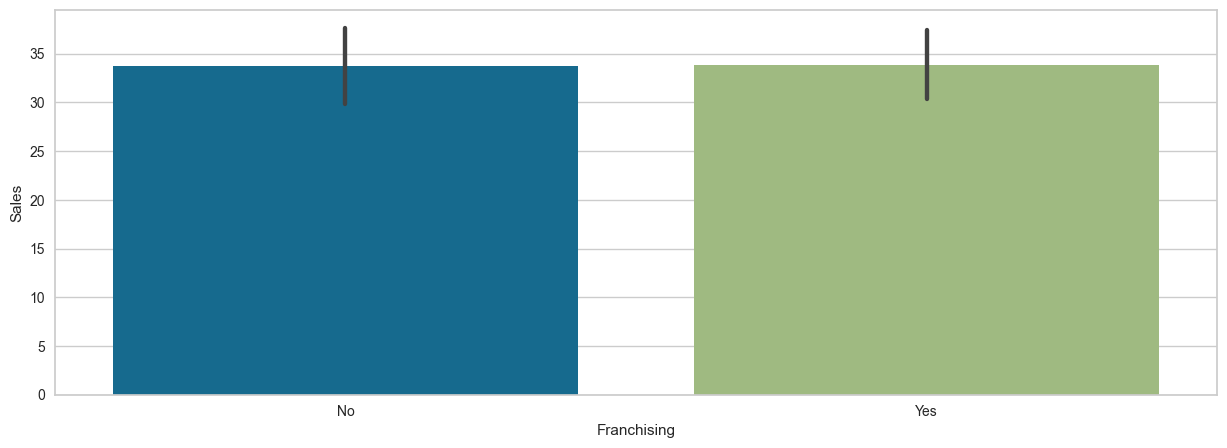

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='Franchising', y='Sales',data=rest_50,ax=ax)
plt.show()

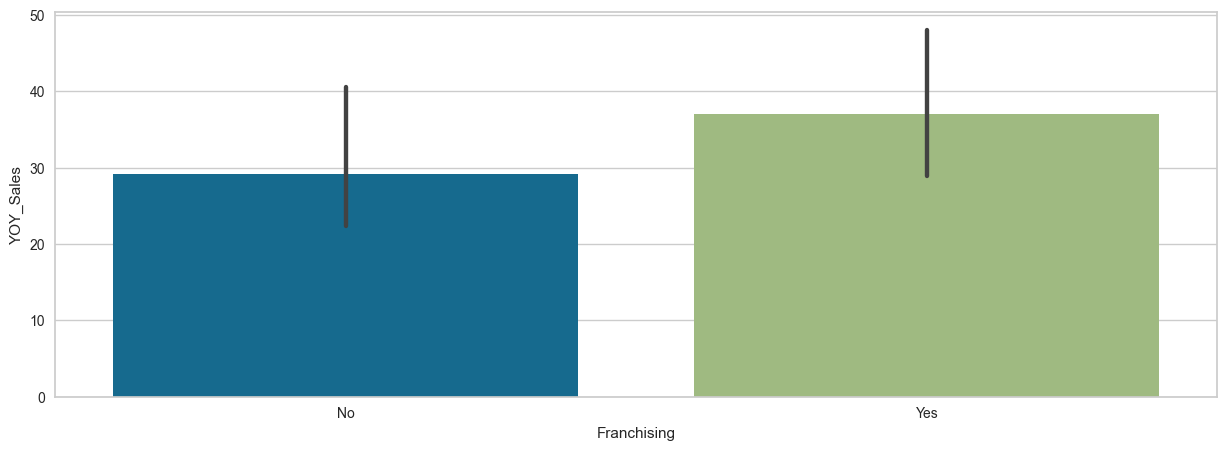

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='Franchising', y='YOY_Sales',data=rest_50,ax=ax)
plt.show()

In [9]:
rest_100 = pd.read_csv('Independence100.csv')

In [10]:
rest_100.head()

,Rank,Restaurant,Sales,Average Check,City,State,Meals Served
0,1,Carmine's (Times Square),39080335.0,40,New York,N.Y.,469803.0
1,2,The Boathouse Orlando,35218364.0,43,Orlando,Fla.,820819.0
2,3,Old Ebbitt Grill,29104017.0,33,Washington,D.C.,892830.0
3,4,LAVO Italian Restaurant & Nightclub,26916180.0,90,New York,N.Y.,198500.0
4,5,Bryant Park Grill & Cafe,26900000.0,62,New York,N.Y.,403000.0


In [11]:
rest_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rank           100 non-null    int64  
 1   Restaurant     100 non-null    object 
 2   Sales          100 non-null    float64
 3   Average Check  100 non-null    int64  
 4   City           100 non-null    object 
 5   State          100 non-null    object 
 6   Meals Served   100 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 5.6+ KB


In [12]:
rest_250 = pd.read_csv('Top250.csv')

In [13]:
rest_250.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Rank              250 non-null    int64 
 1   Restaurant        250 non-null    object
 2   Content           33 non-null     object
 3   Sales             250 non-null    int64 
 4   YOY_Sales         250 non-null    object
 5   Units             250 non-null    int64 
 6   YOY_Units         250 non-null    object
 7   Headquarters      52 non-null     object
 8   Segment_Category  250 non-null    object
dtypes: int64(3), object(6)
memory usage: 17.7+ KB


In [14]:
rest_250.head()

,Rank,Restaurant,Content,Sales,YOY_Sales,Units,YOY_Units,Headquarters,Segment_Category
0,1,McDonald's,NaN,40412,4.9%,13846,-0.5%,NaN,Quick Service & Burger
1,2,Starbucks,NaN,21380,8.6%,15049,3.0%,NaN,Quick Service & Coffee Cafe
2,3,Chick-fil-A,While Popeyes got a lot of the chicken buzz in...,11320,13.0%,2470,5.0%,NaN,Quick Service & Chicken
3,4,Taco Bell,NaN,11293,9.0%,6766,2.7%,NaN,Quick Service & Mexican
4,5,Burger King,NaN,10204,2.7%,7346,0.2%,NaN,Quick Service & Burger


In [15]:
rest_250['Segment_Category'].unique()

array(['Quick Service & Burger', 'Quick Service & Coffee Cafe',
       'Quick Service & Chicken', 'Quick Service & Mexican',
       'Quick Service & Sandwich', 'Quick Service & Pizza',
       'Fast Casual & Bakery Cafe', 'Fast Casual & Mexican',
       'Casual Dining & Italian/Pizza', 'Casual Dining & Varied Menu',
       'Fast Casual & Asian/Noodle', 'Quick Service & Frozen Desserts',
       'Casual Dining & Sports Bar', 'Family Dining & Family Style',
       'Casual Dining & Steak', 'Casual Dining & Seafood',
       'Fast Casual & Sandwich', 'Fast Casual & Chicken',
       'Quick Service & Family Casual', 'Fast Casual & Burger',
       'Casual Dining & Asian', 'Quick Service & Snack', 'Steak',
       'Quick Service & Beverage', 'Sports Bar',
       'Quick Service & Seafood', 'Quick Service & Bakery Cafe',
       'Fast Casual & Pizza', 'Fine Dining & Steak', 'Mexican',
       'Varied Menu', 'Chicken', 'Italian/Pizza', 'Pizza', 'Seafood',
       'Frozen Desserts', 'Coffee Cafe', 'BBQ',

In [16]:
values = ['Quick Service', 'Fast Casual','Casual Dining','Fine Dining']
conditions = list(map(rest_250['Segment_Category'].str.contains, values))

rest_250['Category'] = np.select(conditions, values, 'other')

In [17]:
rest_250.head()

,Rank,Restaurant,Content,Sales,YOY_Sales,Units,YOY_Units,Headquarters,Segment_Category,Category
0,1,McDonald's,NaN,40412,4.9%,13846,-0.5%,NaN,Quick Service & Burger,Quick Service
1,2,Starbucks,NaN,21380,8.6%,15049,3.0%,NaN,Quick Service & Coffee Cafe,Quick Service
2,3,Chick-fil-A,While Popeyes got a lot of the chicken buzz in...,11320,13.0%,2470,5.0%,NaN,Quick Service & Chicken,Quick Service
3,4,Taco Bell,NaN,11293,9.0%,6766,2.7%,NaN,Quick Service & Mexican,Quick Service
4,5,Burger King,NaN,10204,2.7%,7346,0.2%,NaN,Quick Service & Burger,Quick Service


In [18]:
rest_250['Category'].unique()

array(['Quick Service', 'Fast Casual', 'Casual Dining', 'other',
       'Fine Dining'], dtype=object)

In [19]:
values2 = ['Chicken', 'Pizza','Casual Dining','Seafood','Frozen Desserts','Coffee','BBQ','Sandwich','Bakery','Burger','Asian']
conditions2 = list(map(rest_250['Segment_Category'].str.contains, values2))

rest_250['Cuisine'] = np.select(conditions2, values2, 'other')

In [20]:
rest_250.head()

,Rank,Restaurant,Content,Sales,YOY_Sales,Units,YOY_Units,Headquarters,Segment_Category,Category,Cuisine
0,1,McDonald's,NaN,40412,4.9%,13846,-0.5%,NaN,Quick Service & Burger,Quick Service,Burger
1,2,Starbucks,NaN,21380,8.6%,15049,3.0%,NaN,Quick Service & Coffee Cafe,Quick Service,Coffee
2,3,Chick-fil-A,While Popeyes got a lot of the chicken buzz in...,11320,13.0%,2470,5.0%,NaN,Quick Service & Chicken,Quick Service,Chicken
3,4,Taco Bell,NaN,11293,9.0%,6766,2.7%,NaN,Quick Service & Mexican,Quick Service,other
4,5,Burger King,NaN,10204,2.7%,7346,0.2%,NaN,Quick Service & Burger,Quick Service,Burger


In [21]:
rest_250['Content'].isna().value_counts().sum()

250

In [22]:
rest_250['Headquarters'].isna().value_counts().sum()

250

In [23]:
rest_250=rest_250.drop(['Content','Headquarters'], axis=1)

In [24]:
print(rest_250.columns)

Index(['Rank', 'Restaurant', 'Sales', 'YOY_Sales', 'Units', 'YOY_Units',
       'Segment_Category', 'Category', 'Cuisine'],
      dtype='object')


<AxesSubplot: xlabel='Rank', ylabel='Sales'>

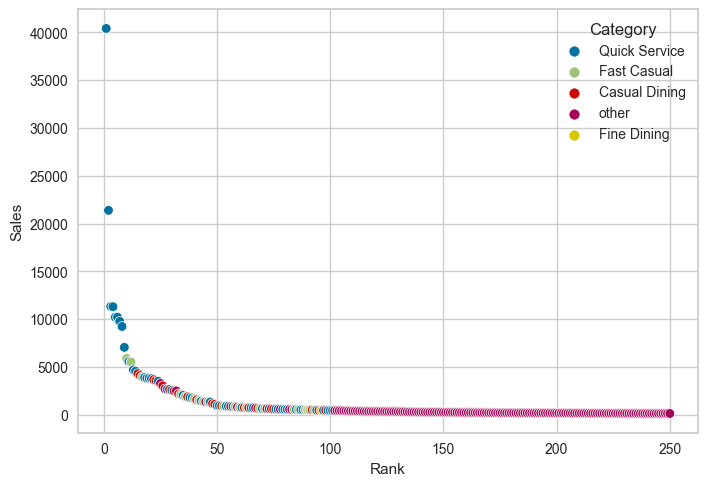

In [25]:
sns.scatterplot(x='Rank', y='Sales',data=rest_250, hue='Category')

As we look at the different restaurant category breakdowns we can see that the quickservice and fast casual restaurants sit at the top of the ranking and sales. This further pushes the narrative that casual and fine dining are sitting at the bottom of the restaurant totem pole.

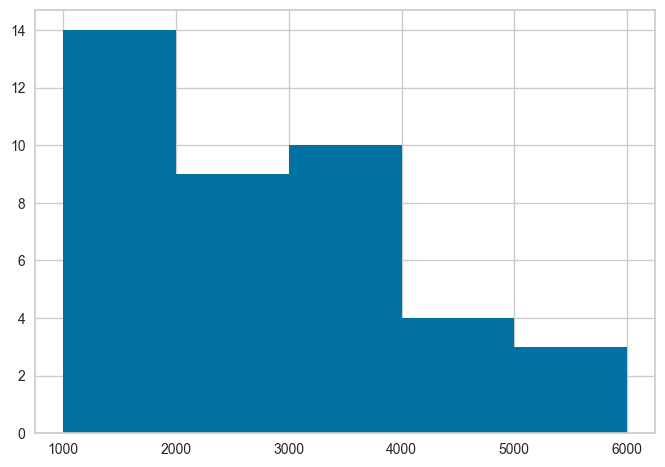

In [26]:
hist = rest_250['Sales'].hist(bins=[1000,2000,3000,4000,5000,6000])

C:\Users\jwatki8\AppData\Local\Temp\ipykernel_2784\1054847787.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = rest_250.corr()


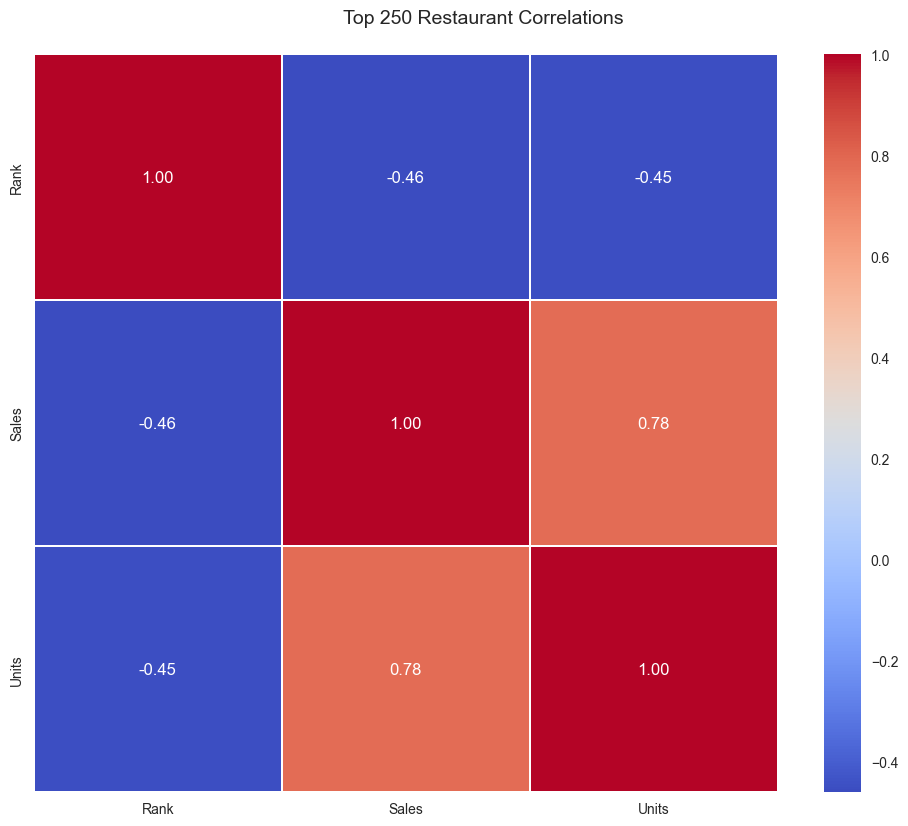

In [27]:
corrmat = rest_250.corr()
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(round(corrmat,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Top 250 Restaurant Correlations', fontsize=14)

In [28]:
sales_mean=rest_250['Sales'].groupby(rest_250['Category']).mean()
print(sales_mean)

Category
Casual Dining    1682.130435
Fast Casual      1557.095238
Fine Dining       461.000000
Quick Service    4096.021277
other             293.183544
Name: Sales, dtype: float64


Let’s take a look at the overall sales for the different categories of restaurants.

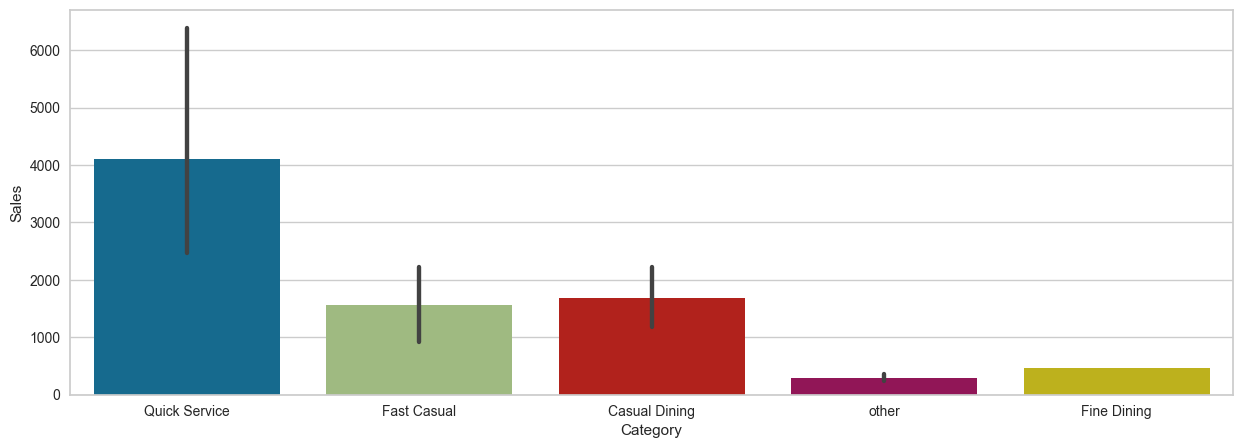

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='Category', y='Sales',data=rest_250,ax=ax)
plt.show()

Quick Service leads the pack once again while casual dining and fine dining lag behind.

So far it seems like the argument that fast food revenue is on the rise over casual sit down restaurants may be true…

But what if it isn’t necessarily restaurant category but cusine type that creates this gap? Let’s take a look.

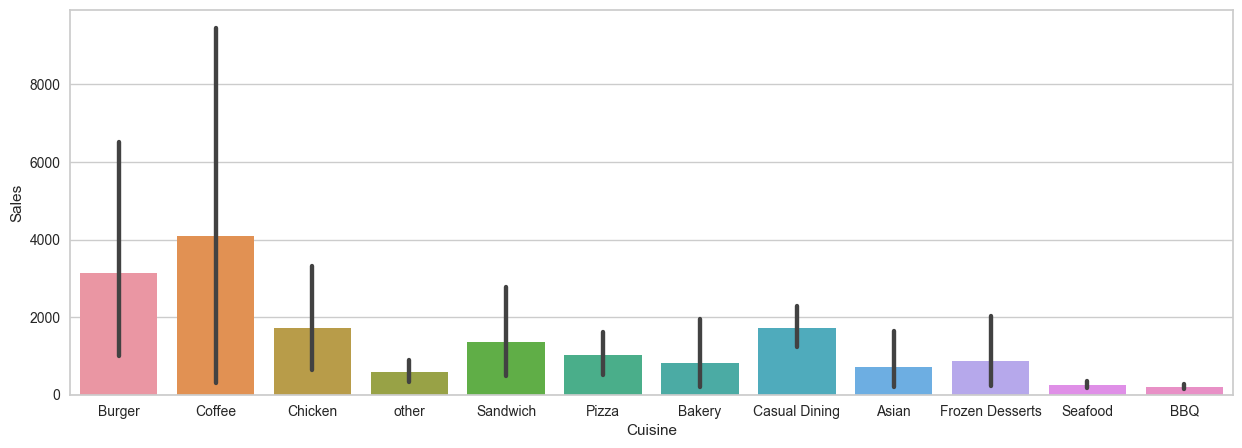

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='Cuisine', y='Sales',data=rest_250,ax=ax)
plt.show()

Even this specific comparison places fast food cuisine like burgers chicken and sandwiches well above not only casual dining cuisine but other cuisine types that generally lend themselves to sit down dining experiences. I almost stopped here!

But since we want to know if this type of 
restaurant is ‘dying’ or on the downslide so 
to speak, maybe we should take a look at 
how sales have changed from the past?

In [31]:
rest_250['YOY_Sales']=rest_250['YOY_Sales'].str.rstrip('%').astype('float')

In [32]:
rest_250['YOY_Units']=rest_250['YOY_Units'].str.rstrip('%').astype('float')

In [33]:
rest_250.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              250 non-null    int64  
 1   Restaurant        250 non-null    object 
 2   Sales             250 non-null    int64  
 3   YOY_Sales         250 non-null    float64
 4   Units             250 non-null    int64  
 5   YOY_Units         250 non-null    float64
 6   Segment_Category  250 non-null    object 
 7   Category          250 non-null    object 
 8   Cuisine           250 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 17.7+ KB


But since we want to know if this type of restaurant is ‘dying’ or on the downslide so to speak, maybe we should take a look at how sales have changed from the past?

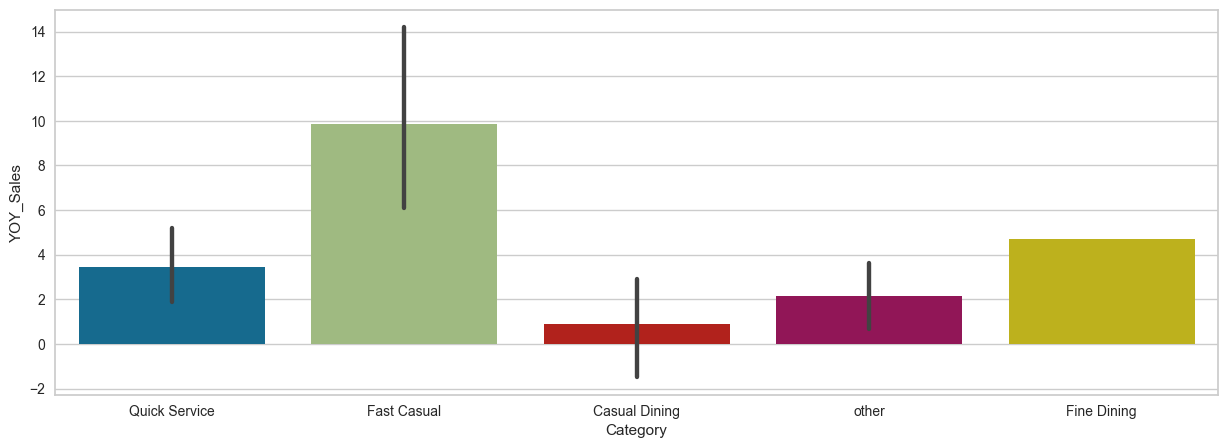

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='Category', y='YOY_Sales',data=rest_250,ax=ax)
plt.show()

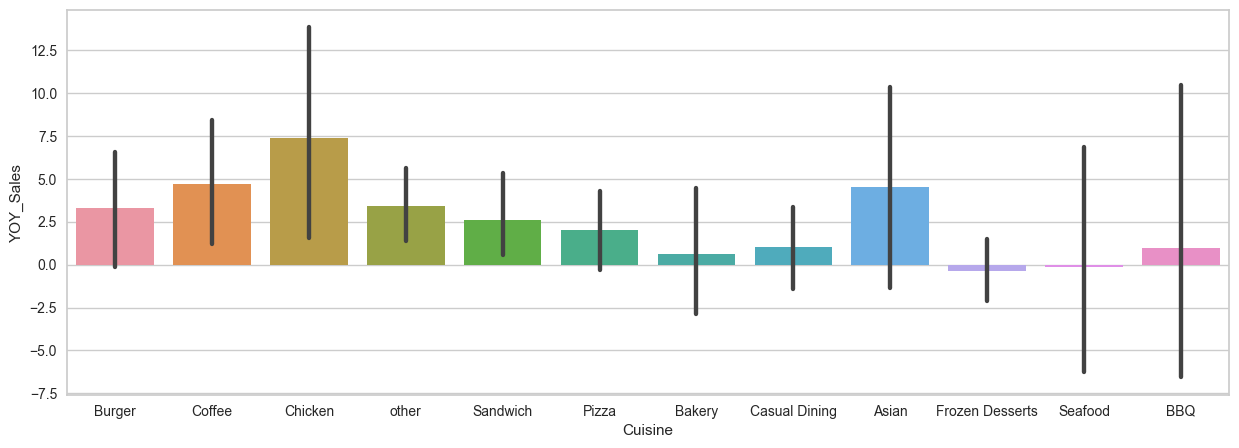

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='Cuisine', y='YOY_Sales',data=rest_250,ax=ax)
plt.show()

We can see from these figures that not only is casual dining down from the previous year, casual dining cuisine types actually have negative average sales differences from the previous year.

So I guess we have to throw in the towel and assume 
people just don’t want to take the time to sit down and 
have a meal in a restaurant the way they used to right? 
After all the data always tells the truth right? But is the 
data telling us the whole truth? 


What if I told you that this data was representative of restaurant 
financials from the year 2020? Can you think of a few factors 
about this year that would affect sit down restaurant revenue? 
That’s right folks this data comes from a year where people, 
for good reason, were absolutely less inclined to dine at a 
casual sit down restaurant. 


So before everybody starts to move their 401k from Maggiano's into 
Burger King stock, maybe we should wait a while and give people a chance 
to get back into the rotation of having their regular Saturday date nights 
and family meals at their favorite restaurants. The casual sit down dining 
experience might still be as big a part of human culture as it has been for 
many years.
